In [33]:
import pandas as pd

# Load your data into a DataFrame
df = pd.read_csv('data/food_crises_cleaned.csv')


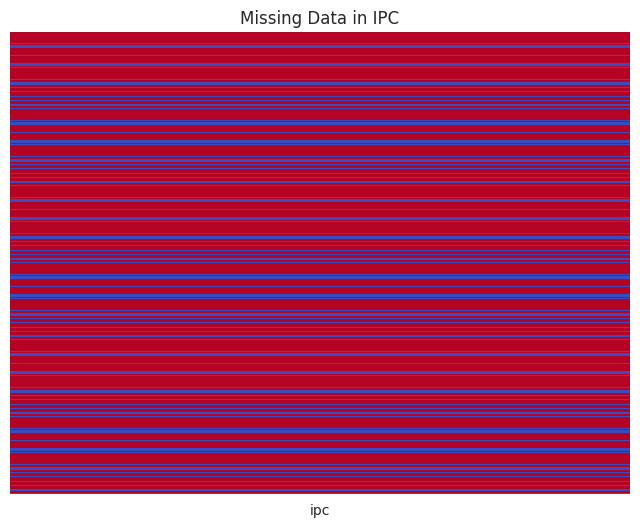

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a missing data heatmap for the column of interest using the 'coolwarm' colormap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['ipc']].isnull(), cmap='coolwarm', cbar=False, yticklabels=False)
plt.title('Missing Data in IPC')
plt.show()


In [6]:
# Calculate summary statistics for the column with missing data
summary_stats = df[['ipc']].describe()

# Compare statistics for missing and non-missing values
summary_stats_missing = df[df['ipc'].isnull()][['ipc']].describe()
summary_stats_not_missing = df[~df['ipc'].isnull()][['ipc']].describe()

print("Summary statistics for missing values:")
print(summary_stats_missing)

print("\nSummary statistics for non-missing values:")
print(summary_stats_not_missing)


Summary statistics for missing values:
       ipc
count  0.0
mean   NaN
std    NaN
min    NaN
25%    NaN
50%    NaN
75%    NaN
max    NaN

Summary statistics for non-missing values:
               ipc
count  3042.000000
mean      2.124918
std       0.896948
min       1.000000
25%       1.000000
50%       2.000000
75%       3.000000
max       5.000000


In [7]:
# Calculate correlations with other columns
correlation_matrix = df.corr()

# Extract the correlation with the column of interest
correlation_with_column = correlation_matrix['ipc']

print("Correlation with other columns:")
print(correlation_with_column)


Correlation with other columns:
district_code      0.232751
centx              0.084513
centy              0.246221
year               0.612337
month              0.021450
ipc                1.000000
ha                 0.158948
ndvi_mean         -0.021316
ndvi_anom          0.208910
rain_mean          0.007412
rain_anom          0.086770
et_mean           -0.055851
et_anom            0.068227
count_violence     0.121199
sum_fatalities     0.042918
food_price_idx     0.553037
area              -0.014956
cropland_pct      -0.006450
pop                0.077619
ruggedness_mean   -0.151872
pasture_pct        0.321639
Name: ipc, dtype: float64


In [16]:
df['date'].head()

0    2007-01-01
1    2007-02-01
2    2007-03-01
3    2007-04-01
4    2007-05-01
Name: date, dtype: object

In [18]:
df['year_month'].head()

0    2007_01
1    2007_02
2    2007_03
3    2007_04
4    2007_05
Name: year_month, dtype: object

In [21]:
import statsmodels.api as sm
import datetime

# Split 'year_month' into 'year' and 'month' columns
df['year'] = df['year_month'].str.split('_').str[0].astype(int)
df['month'] = df['year_month'].str.split('_').str[1].astype(int)

# Define a reference date (e.g., '2007-01-01' for the first day of the first month)
reference_date = datetime.datetime(2007, 1, 1)

# Calculate the number of months since the reference date
df['year_month_numeric'] = (df['year'] - reference_date.year) * 12 + (df['month'] - reference_date.month)


# Create a binary indicator variable for missingness in the column of interest
df['missing_indicator'] = df['ipc'].isnull().astype(int)

# Fit a logistic regression model to predict the missingness
model = sm.Logit(df['missing_indicator'], sm.add_constant(df[['year_month_numeric']]))  # Add other relevant variables
results = model.fit()

# Perform Little's MCAR test
mcar_test = results.prsquared
print("Little's MCAR Test p-value:", mcar_test)



Optimization terminated successfully.
         Current function value: 0.549511
         Iterations 5
Little's MCAR Test p-value: 0.016679300591537882


In [24]:
# Calculate the percentage of missing values for the column of interest
missing_percentage = (df['ipc'].isnull().sum() / len(df)) * 100
print(f"Percentage of missing values in ipc: {missing_percentage:.2f}%")


Percentage of missing values in ipc: 75.32%


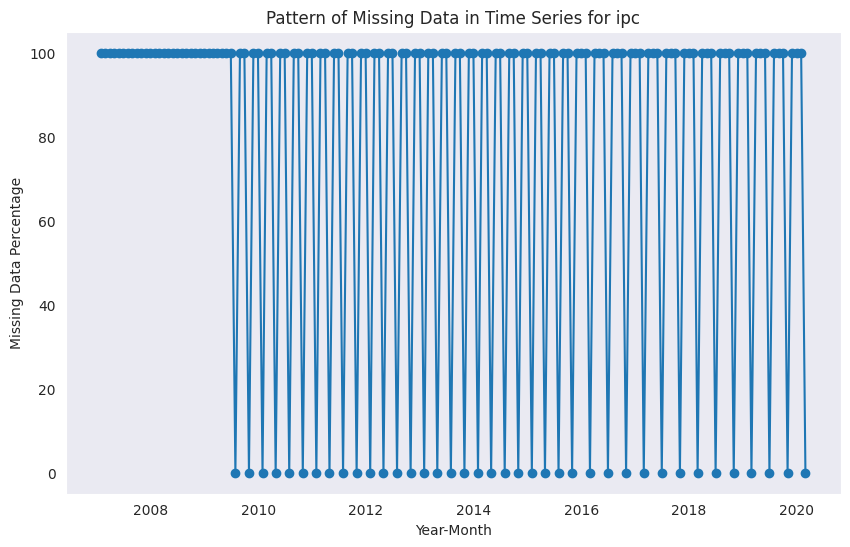

In [40]:
import matplotlib.pyplot as plt

# Create a sample DataFrame with mixed date formats
data = {'year_month': ['2007-01-01', '2007-02-01', '2007-03-01', '2007_04', '2007_05', '2007_06'],
        'ipc': [1, 2, 3, 4, 5, 6]}

df1 = pd.DataFrame(data)

# Function to convert mixed date formats into a datetime column
def convert_to_datetime(value):
    try:
        return pd.to_datetime(value, format='%Y-%m-%d')
    except ValueError:
        parts = value.split('_')
        year = int(parts[0])
        month = int(parts[1])
        return pd.to_datetime(f'{year}-{month:02d}', format='%Y-%m')

# Apply the conversion function to the 'year_month' column
df['datetime'] = df['year_month'].apply(convert_to_datetime)

# Set the 'date' column as the index
df.set_index('datetime', inplace=True)

# Calculate the missing data percentage for each time point
missing_data_percentage = df['ipc'].isnull().astype(int).resample('M').mean() * 100

# Plot the missing data percentage over time (monthly)
plt.figure(figsize=(10, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xlabel('Year-Month')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc')
plt.grid()
plt.show()

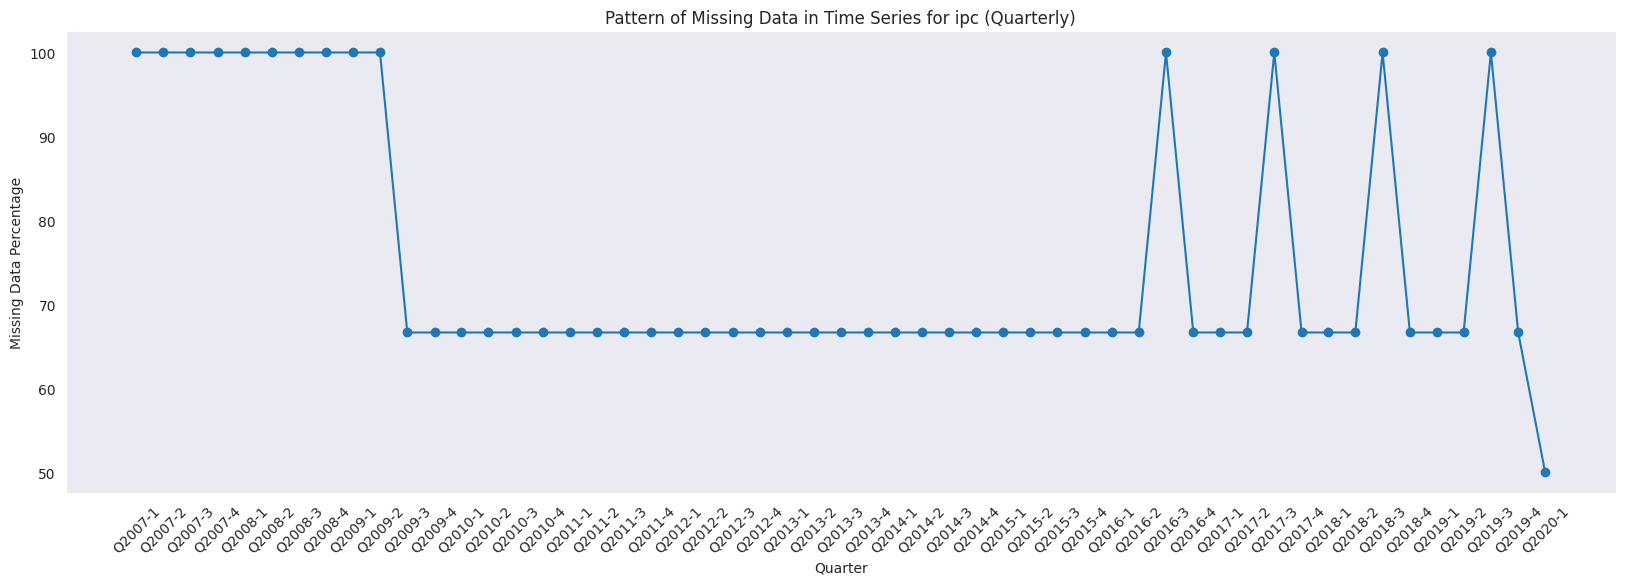

In [49]:

# Function to convert mixed date formats into a datetime column
def convert_to_datetime(value):
    try:
        return pd.to_datetime(value, format='%Y-%m-%d')
    except ValueError:
        parts = value.split('_')
        year = int(parts[0])
        month = int(parts[1])
        return pd.to_datetime(f'{year}-{month:02d}', format='%Y-%m')

# Apply the conversion function to the 'year_month' column
df['quarter'] = df['year_month'].apply(convert_to_datetime)

# Set the 'date' column as the index
df.set_index('quarter', inplace=True)

# Calculate the missing data percentage for each quarter
missing_data_percentage = df['ipc'].isnull().astype(int).resample('Q').mean() * 100
quarters = [f'Q{quarter.year}-{quarter.quarter}' for quarter in missing_data_percentage.index]

# Plot the missing data percentage over time (quarterly)
plt.figure(figsize=(20, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xticks(missing_data_percentage.index, quarters, rotation=45)  # Set custom x-labels and rotate for readability
plt.xlabel('Quarter')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc (Quarterly)')
plt.grid()
plt.show()
